In [ ]:
!pip install --upgrade mlflow google-meridian[colab,and-cuda]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import arviz as az
import IPython
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder
from meridian.data import test_utils
from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec
from meridian import mlflow

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

--------------
# Reading in the simulated data

We will read in the csv file and start the exploratory data analysis.

In [4]:
import os
file_path = "/content/drive/MyDrive/Google Meridian/Simulated_Data_RF.csv"
os.path.exists(file_path)

True

In [5]:
sim_data = pd.read_csv(file_path, index_col = 0)

In [6]:
print(sim_data.shape)
print(sim_data.columns)
print(sim_data.head)

(6240, 25)
Index(['geo', 'time', 'Channel0_impression', 'Channel1_impression',
       'Channel2_impression', 'Channel3_impression', 'Channel4_impression',
       'Channel5_impression', 'Competitor_Discount', 'GQV', 'Geo_GDP',
       'Channel0_spend', 'Channel1_spend', 'Channel2_spend', 'Channel3_spend',
       'Channel4_spend', 'Channel5_spend', 'conversions',
       'revenue_per_conversion', 'population', 'geo_tier', 'Channel4_reach',
       'Channel5_reach', 'Channel4_frequency', 'Channel5_frequency'],
      dtype='object')
<bound method NDFrame.head of        geo        time  Channel0_impression  Channel1_impression  \
0     Geo0  2021-01-25                  0.0                  0.0   
1     Geo0  2021-02-01                  0.0                  0.0   
2     Geo0  2021-02-08             547840.0             242085.0   
3     Geo0  2021-02-15                  0.0                  0.0   
4     Geo0  2021-02-22             832513.0                  0.0   
...    ...         ...        

In [7]:
sim_data.describe()

,Channel0_impression,Channel1_impression,Channel2_impression,Channel3_impression,Channel4_impression,Channel5_impression,Competitor_Discount,GQV,Geo_GDP,Channel0_spend,...,Channel4_spend,Channel5_spend,conversions,revenue_per_conversion,population,geo_tier,Channel4_reach,Channel5_reach,Channel4_frequency,Channel5_frequency
count,6.240000e+03,6.240000e+03,6.240000e+03,6.240000e+03,6.240000e+03,6.240000e+03,6240.000000,6240.000000,6240.000000,6240.000000,...,6240.000000,6240.000000,6.240000e+03,6240.000000,6240.000000,6240.000000,6.240000e+03,6.240000e+03,6240.000000,6240.000000
mean,6.385794e+05,2.749724e+05,4.729708e+05,5.354220e+05,6.064253e+05,5.140087e+05,0.000818,-0.023583,-0.019670,5480.446911,...,4938.426712,4028.876323,9.549858e+06,0.019999,542620.095750,2.125000,2.487941e+05,2.096576e+05,1.446265,1.223056
std,7.837601e+05,5.029426e+05,6.342561e+05,6.552248e+05,7.883364e+05,7.740321e+05,1.150635,1.273087,1.236413,6726.423962,...,6419.819993,6066.978338,4.841259e+06,0.000101,242633.010852,0.747974,2.569801e+05,2.551570e+05,1.281389,1.288332
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.492474,-5.257075,-3.984428,0.000000,...,0.000000,0.000000,6.508473e+05,0.019619,126458.920000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.758388,-0.897872,-0.865686,0.000000,...,0.000000,0.000000,5.695526e+06,0.019930,333105.530000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.736805e+05,0.000000e+00,2.090445e+05,3.080065e+05,3.056145e+05,1.344295e+05,0.002176,0.006349,-0.028022,3207.019050,...,2488.772600,1053.678350,8.915102e+06,0.019998,583811.550000,2.000000,1.881995e+05,1.029415e+05,1.403186,1.134813
75%,9.723832e+05,3.555588e+05,7.495985e+05,8.408448e+05,9.376585e+05,7.666492e+05,0.786248,0.864719,0.820586,8345.234750,...,7635.825175,6009.110250,1.292518e+07,0.020066,705583.625000,3.000000,4.269468e+05,3.762690e+05,2.296064,2.105500
max,5.279476e+06,4.375904e+06,4.677352e+06,4.455026e+06,5.857052e+06,6.425844e+06,4.267711,4.890409,4.454445,45309.777000,...,47696.920000,50366.715000,3.394492e+07,0.020350,988566.400000,3.000000,1.056931e+06,1.041760e+06,7.806343,7.410372


array([[<Axes: title={'center': 'Channel0_impression'}>,
        <Axes: title={'center': 'Channel1_impression'}>,
        <Axes: title={'center': 'Channel2_impression'}>,
        <Axes: title={'center': 'Channel3_impression'}>,
        <Axes: title={'center': 'Channel4_impression'}>],
       [<Axes: title={'center': 'Channel5_impression'}>,
        <Axes: title={'center': 'Competitor_Discount'}>,
        <Axes: title={'center': 'GQV'}>,
        <Axes: title={'center': 'Geo_GDP'}>,
        <Axes: title={'center': 'Channel0_spend'}>],
       [<Axes: title={'center': 'Channel1_spend'}>,
        <Axes: title={'center': 'Channel2_spend'}>,
        <Axes: title={'center': 'Channel3_spend'}>,
        <Axes: title={'center': 'Channel4_spend'}>,
        <Axes: title={'center': 'Channel5_spend'}>],
       [<Axes: title={'center': 'conversions'}>,
        <Axes: title={'center': 'revenue_per_conversion'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'geo_tier'}

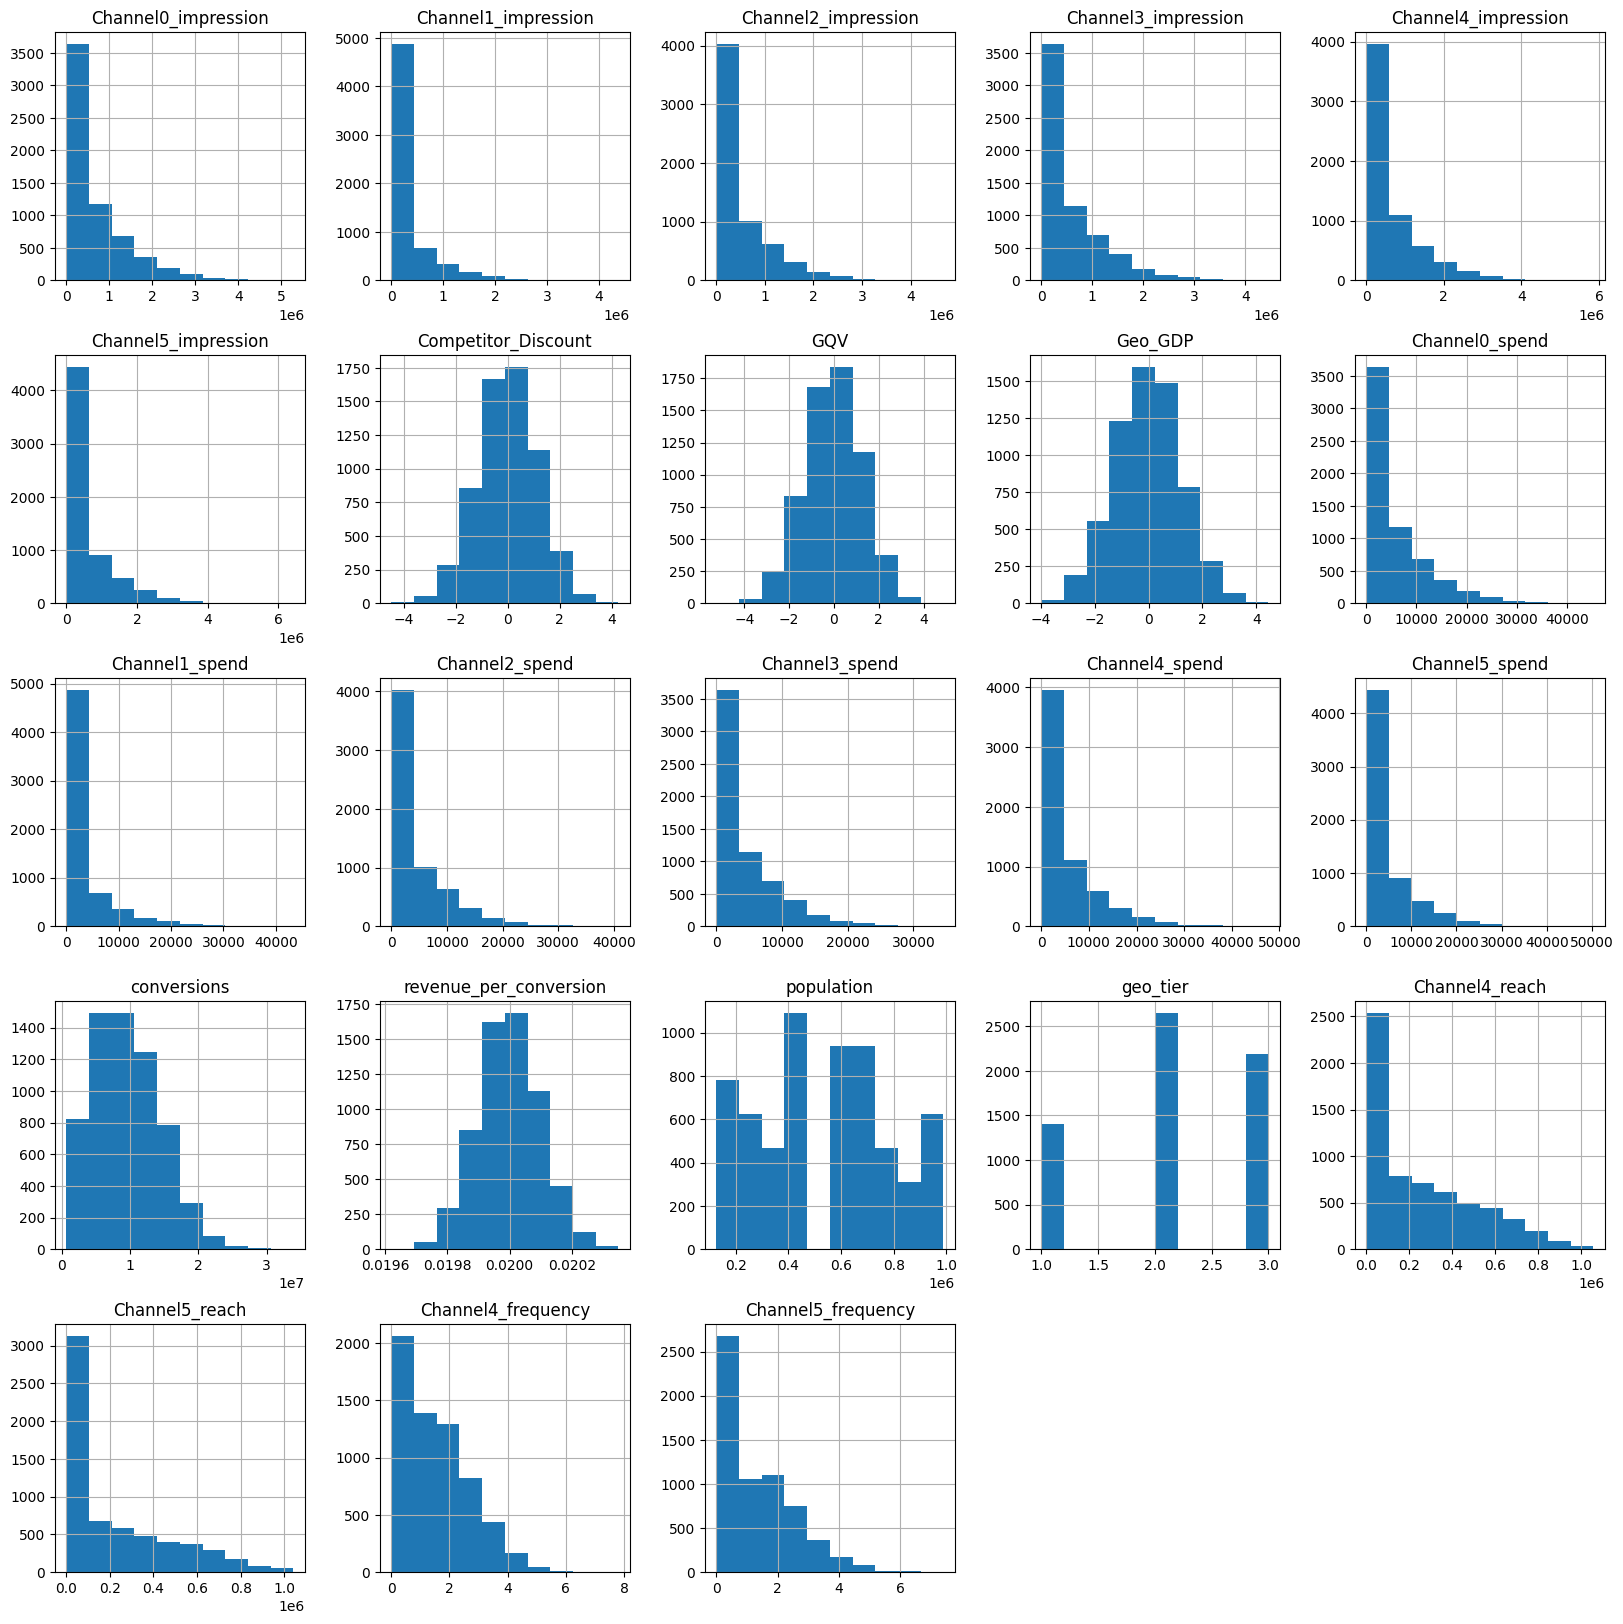

In [8]:
sim_data.hist(figsize = (20, 20))

-------
# Building the model object

We will now build the model object using the builder module

In [9]:
builder = data_frame_input_data_builder.DataFrameInputDataBuilder(
    kpi_type = "non_revenue",
    default_kpi_column = "conversions",
    default_revenue_per_kpi_column = "revenue_per_conversion",
)

builder = (
    builder.with_kpi(df =sim_data, kpi_col = "conversions")
    .with_revenue_per_kpi(df = sim_data, revenue_per_kpi_col = "revenue_per_conversion")
    .with_population(df = sim_data)
    .with_controls(
        df = sim_data,
        control_cols = ["Competitor_Discount", "GQV", "Geo_GDP"],
        time_col = "time",
        geo_col = "geo"
    )
)

channels = [f"Channel" + str(i) for i in range(0, 4)]

builder = builder.with_media(
    df = sim_data,
    media_cols = [f"{channel}_impression" for channel in channels],
    media_spend_cols = [f"{channel}_spend" for channel in channels],
    media_channels = channels,
)

channels_rf = [f"Channel" + str(i) for i in range(4, 6)]
data = builder.with_reach(
    df = sim_data,
    reach_cols = [f"{channel}_reach" for channel in channels_rf],
    frequency_cols = [f"{channel}_frequency" for channel in channels_rf],
    rf_spend_cols = [f"{channel}_spend" for channel in channels_rf],
    rf_channels = channels_rf
)

data = builder.build()

Preparing the model specification

In [11]:
# Media Channels
roi_m_mu = [0.3, 0.2, 0.3, 0.4]
roi_m_sigma = [0.7, 0.7, 0.9, 0.6]
# Reach and frequency
roi_rf_mu = [0.3, 0.3]
roi_rf_sigma = [0.7, 0.6]

prior = prior_distribution.PriorDistribution(
   roi_m = tfp.distributions.LogNormal(roi_m_mu, roi_m_sigma, name = constants.ROI_M),
   roi_rf = tfp.distributions.LogNormal(roi_rf_mu, roi_rf_sigma, name = constants.ROI_RF)
)

In [12]:
model_spec = spec.ModelSpec(
    prior = prior,
    knots = 10,
    max_lag = 6,
    hill_before_adstock = False,
    unique_sigma_for_each_geo = True,

    media_prior_type = "roi",
    roi_calibration_period = None,

    rf_prior_type = "roi",
    rf_roi_calibration_period = None,

    organic_media_prior_type = "contribution",
    organic_rf_prior_type = "contribution",

    non_media_treatments_prior_type = "contribution",

    baseline_geo = None,
    holdout_id = None,

    control_population_scaling_id = None,
)

--------
# Model Run


In [13]:
%%time
import mlflow
with mlflow.start_run(run_name = "MyRun"):
  mmm = model.Meridian(input_data = data, model_spec = model_spec)
  mmm.sample_prior(500)
  mmm.sample_posterior(n_chains = 7,
                       n_adapt = 500,
                       n_burnin = 500,
                       n_keep = 1000,
                       seed = 42)

CPU times: user 10min 46s, sys: 20.8 s, total: 11min 7s
Wall time: 11min 22s


In [14]:
client = mlflow.tracking.MlflowClient()
experiment_id = "0"
runs = client.search_runs(
    experiment_id,
    max_results = 1000,
    filter_string = f"attributes.run_name = 'MyRun'"
)
if runs:
  print(runs[0])
else:
  print("No runs found.")

<Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'MyRun',
 'mlflow.source.name': '/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'root'}>, info=<RunInfo: artifact_uri='file:///content/mlruns/0/703a90bd3f814c13b907b1ffe0b97309/artifacts', end_time=1754802166241, experiment_id='0', lifecycle_stage='active', run_id='703a90bd3f814c13b907b1ffe0b97309', run_name='MyRun', start_time=1754801484351, status='FINISHED', user_id='root'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>


------
# Model Diagnostics


In [15]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)

In [16]:
model_diagnostics.predictive_accuracy_table()

,metric,geo_granularity,value
0,R_Squared,geo,0.979372
1,R_Squared,national,0.901092
2,MAPE,geo,0.058168
3,MAPE,national,0.023580
4,wMAPE,geo,0.052870
5,wMAPE,national,0.023530


In [17]:
model_diagnostics.plot_prior_and_posterior_distribution()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

### Model output

In [24]:
mmm_summarizer = summarizer.Summarizer(mmm)

filepath = "/content/drive/MyDrive/Google Meridian/"

start_date = "2021-01-25"
end_date = "2024-01-15"

mmm_summarizer.output_model_results_summary(
    "summary_output_SaptarishiPandey.html", filepath, start_date, end_date
)

IPython.display.HTML(filename = f"{filepath}summary_output_SaptarishiPandey.html")

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:3103: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(


Dataset,R-squared,MAPE,wMAPE
All Data,0.90,2%,2%


------
# Budget Optimization

We will optimize for marginal ROI

In [25]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

In [38]:
margROI_optimization_results = budget_optimizer.optimize(
    start_date = "2023-01-16",
    end_date = "2024-01-15",
    fixed_budget = False,
    spend_constraint_lower = 0.01,
    spend_constraint_upper = 0.55,
    target_mroi = 0.9)

/usr/local/lib/python3.11/dist-packages/meridian/analysis/optimizer.py:2924: UserWarning: Target marginal ROI constraint was not met. The target marginal ROI is 0.9, but the actual channel marginal ROIs are <xarray.DataArray 'mroi' (channel: 6)> Size: 24B
array([0.5968568 , 0.76719636, 0.29612872, 0.43008354, 0.8381361 ,
       1.3089454 ], dtype=float32)
Coordinates:
  * channel  (channel) object 48B 'Channel0' 'Channel1' ... 'Channel5'
    metric   <U6 24B 'mean'.
  warnings.warn(


In [40]:
margROI_optimization_results.plot_budget_allocation(optimized = True)

alt.Chart(...)

-------
# Save model object

In [41]:
model.save_mmm(mmm, file_path = "/content/drive/MyDrive/Google Meridian/mmm_SaptarishiPandey.pkl")